# Phase 1: Fast Baseline Features (Tabular)

## Objectives
1. Create comprehensive tabular features from P2P transaction data
2. Implement anti-leakage temporal feature engineering
3. Build and evaluate baseline fraud detection model
4. Establish performance benchmark for graph feature comparison

## Feature Categories
- **Amount features**: raw, log1p, z-scores
- **Activity features**: transaction counts, unique partners, cumulative amounts
- **Velocity features**: time since last activity, transaction frequency
- **Pair familiarity**: relationship strength between accounts

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib

# Set style
plt.style.use('default')
sns.set_palette('husl')

print("📚 Libraries loaded successfully!")
print("🚀 Ready for Phase 1: Fast Baseline Features")

📚 Libraries loaded successfully!
🚀 Ready for Phase 1: Fast Baseline Features


## 1. Load Processed Data from Phase 0

In [2]:
# Load the processed data from Phase 0
processed_path = Path('processed_data')

if processed_path.exists():
    train_df = pd.read_csv(processed_path / 'train_features.csv')
    val_df = pd.read_csv(processed_path / 'val_features.csv')
    
    # Parse timestamps
    train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
    val_df['timestamp'] = pd.to_datetime(val_df['timestamp'])
    
    print(f"✅ Loaded processed data:")
    print(f"   Training: {len(train_df):,} transactions")
    print(f"   Validation: {len(val_df):,} transactions")
    print(f"   Features from Phase 0: {train_df.columns.tolist()}")
else:
    print("❌ Processed data not found. Please run Phase 0 first.")
    raise FileNotFoundError("Run Phase 0 notebook first to generate processed_data/")

✅ Loaded processed data:
   Training: 56,000 transactions
   Validation: 14,000 transactions
   Features from Phase 0: ['p2p_id', 'timestamp', 'sender_account_id', 'receiver_account_id', 'amount', 'currency', 'is_fraud_truth', 'is_fraud', 'amount_log1p', 'amount_zscore', 'sender_amount_zscore', 'receiver_amount_zscore']


## 2. Enhanced Temporal Feature Engineering Framework

In [5]:
class AdvancedTemporalFeatureEngineer:
    """Enhanced feature engineering with comprehensive anti-leakage protection"""
    
    def __init__(self):
        self.fitted_stats = {}
        self.split_timestamp = None
        self.feature_names = []
        
    def _safe_divide(self, numerator, denominator, default=0):
        """Safe division avoiding divide by zero"""
        return np.where(denominator != 0, numerator / denominator, default)
    
    def _compute_temporal_features(self, df, is_validation=False):
        """Compute all temporal features ensuring no future data leakage"""
        
        print(f"🔄 Computing temporal features for {len(df):,} transactions...")
        
        # Initialize feature columns
        features = df.copy()
        
        # Pre-allocate arrays for efficiency
        n_transactions = len(df)
        
        # Activity features
        sender_tx_count = np.zeros(n_transactions)
        receiver_tx_count = np.zeros(n_transactions)
        sender_unique_partners = np.zeros(n_transactions)
        receiver_unique_partners = np.zeros(n_transactions)
        sender_total_amt = np.zeros(n_transactions)
        receiver_total_amt = np.zeros(n_transactions)
        
        # Velocity features
        sender_time_since_last = np.full(n_transactions, np.inf)
        receiver_time_since_last = np.full(n_transactions, np.inf)
        
        # Pair familiarity features
        pair_tx_count = np.zeros(n_transactions)
        pair_total_amount = np.zeros(n_transactions)
        pair_time_since_last = np.full(n_transactions, np.inf)
        
        # Tracking dictionaries (use only past data)
        sender_history = {}
        receiver_history = {}
        pair_history = {}
        
        # Process each transaction in temporal order
        for idx in range(n_transactions):
            if idx % 5000 == 0:
                print(f"   Progress: {idx:,}/{n_transactions:,} ({idx/n_transactions*100:.1f}%)")
            
            row = df.iloc[idx]
            sender = row['sender_account_id']
            receiver = row['receiver_account_id']
            amount = row['amount']
            timestamp = row['timestamp']
            pair_key = (sender, receiver)
            
            # --- SENDER FEATURES (based on past activity) ---
            if sender in sender_history:
                sender_data = sender_history[sender]
                sender_tx_count[idx] = sender_data['count']
                sender_unique_partners[idx] = len(sender_data['partners'])
                sender_total_amt[idx] = sender_data['total_amt']
                sender_time_since_last[idx] = (timestamp - sender_data['last_timestamp']).total_seconds() / 3600  # hours
            
            # --- RECEIVER FEATURES (based on past activity) ---
            if receiver in receiver_history:
                receiver_data = receiver_history[receiver]
                receiver_tx_count[idx] = receiver_data['count']
                receiver_unique_partners[idx] = len(receiver_data['partners'])
                receiver_total_amt[idx] = receiver_data['total_amt']
                receiver_time_since_last[idx] = (timestamp - receiver_data['last_timestamp']).total_seconds() / 3600  # hours
            
            # --- PAIR FEATURES (based on past interactions) ---
            if pair_key in pair_history:
                pair_data = pair_history[pair_key]
                pair_tx_count[idx] = pair_data['count']
                pair_total_amount[idx] = pair_data['total_amount']
                pair_time_since_last[idx] = (timestamp - pair_data['last_timestamp']).total_seconds() / 3600  # hours
            
            # --- UPDATE HISTORY (for next transaction) ---
            # Update sender history
            if sender not in sender_history:
                sender_history[sender] = {'count': 0, 'partners': set(), 'total_amt': 0, 'last_timestamp': timestamp}
            sender_history[sender]['count'] += 1
            sender_history[sender]['partners'].add(receiver)
            sender_history[sender]['total_amt'] += amount
            sender_history[sender]['last_timestamp'] = timestamp
            
            # Update receiver history
            if receiver not in receiver_history:
                receiver_history[receiver] = {'count': 0, 'partners': set(), 'total_amt': 0, 'last_timestamp': timestamp}
            receiver_history[receiver]['count'] += 1
            receiver_history[receiver]['partners'].add(sender)
            receiver_history[receiver]['total_amt'] += amount
            receiver_history[receiver]['last_timestamp'] = timestamp
            
            # Update pair history
            if pair_key not in pair_history:
                pair_history[pair_key] = {'count': 0, 'total_amount': 0, 'last_timestamp': timestamp}
            pair_history[pair_key]['count'] += 1
            pair_history[pair_key]['total_amount'] += amount
            pair_history[pair_key]['last_timestamp'] = timestamp
        
        # Assign computed features
        features['sender_tx_count'] = sender_tx_count
        features['receiver_tx_count'] = receiver_tx_count
        features['sender_unique_partners'] = sender_unique_partners
        features['receiver_unique_partners'] = receiver_unique_partners
        features['sender_total_amt'] = sender_total_amt
        features['receiver_total_amt'] = receiver_total_amt
        
        features['sender_hours_since_last'] = np.where(sender_time_since_last == np.inf, 24*30, sender_time_since_last)  # Cap at 30 days
        features['receiver_hours_since_last'] = np.where(receiver_time_since_last == np.inf, 24*30, receiver_time_since_last)
        
        features['pair_tx_count'] = pair_tx_count
        features['pair_total_amount'] = pair_total_amount
        features['pair_hours_since_last'] = np.where(pair_time_since_last == np.inf, 24*30, pair_time_since_last)
        
        print(f"✅ Temporal features computed successfully!")
        return features
    
    def _compute_derived_features(self, features):
        """Compute derived features from base temporal features"""
        
        print("🔄 Computing derived features...")
        
        # Amount features (already computed in Phase 0, but add more)
        features['amount_log1p'] = np.log1p(features['amount'])
        features['amount_sqrt'] = np.sqrt(features['amount'])
        
        # Velocity features
        features['sender_tx_frequency'] = self._safe_divide(features['sender_tx_count'], 
                                                          features['sender_hours_since_last'] + 1, default=0)
        features['receiver_tx_frequency'] = self._safe_divide(features['receiver_tx_count'], 
                                                            features['receiver_hours_since_last'] + 1, default=0)
        
        # Network diversity features
        features['sender_partner_ratio'] = self._safe_divide(features['sender_unique_partners'], 
                                                           features['sender_tx_count'], default=0)
        features['receiver_partner_ratio'] = self._safe_divide(features['receiver_unique_partners'], 
                                                             features['receiver_tx_count'], default=0)
        
        # Average amount features
        features['sender_avg_amount'] = self._safe_divide(features['sender_total_amt'], 
                                                        features['sender_tx_count'], default=0)
        features['receiver_avg_amount'] = self._safe_divide(features['receiver_total_amt'], 
                                                          features['receiver_tx_count'], default=0)
        features['pair_avg_amount'] = self._safe_divide(features['pair_total_amount'], 
                                                      features['pair_tx_count'], default=0)
        
        # Pair familiarity strength
        features['pair_familiarity_score'] = (features['pair_tx_count'] * np.log1p(features['pair_total_amount']))
        features['is_first_interaction'] = (features['pair_tx_count'] == 0).astype(int)
        
        # Amount deviation features (how unusual is this amount?)
        features['amount_vs_sender_avg'] = self._safe_divide(features['amount'], 
                                                           features['sender_avg_amount'] + 1, default=1)
        features['amount_vs_receiver_avg'] = self._safe_divide(features['amount'], 
                                                             features['receiver_avg_amount'] + 1, default=1)
        features['amount_vs_pair_avg'] = self._safe_divide(features['amount'], 
                                                         features['pair_avg_amount'] + 1, default=1)
        
        # Time-based features
        features['is_weekend'] = features['timestamp'].dt.dayofweek.isin([5, 6]).astype(int)
        features['hour_of_day'] = features['timestamp'].dt.hour
        night_hours = list(range(22, 24)) + list(range(0, 6))  # 10PM-12AM and 12AM-6AM
        features['is_night_transaction'] = features['hour_of_day'].isin(night_hours).astype(int)
        
        print(f"✅ Derived features computed successfully!")
        return features
    
    def fit(self, train_df, split_timestamp):
        """Fit feature engineering pipeline on training data"""
        print(f"🔧 Fitting feature engineer on {len(train_df):,} training samples...")
        
        self.split_timestamp = split_timestamp
        
        # Compute temporal features
        train_features = self._compute_temporal_features(train_df, is_validation=False)
        train_features = self._compute_derived_features(train_features)
        
        # Fit normalization statistics (for z-scores) on training data only
        numeric_columns = train_features.select_dtypes(include=[np.number]).columns
        self.fitted_stats['feature_means'] = train_features[numeric_columns].mean().to_dict()
        self.fitted_stats['feature_stds'] = train_features[numeric_columns].std().to_dict()
        
        # Store feature names
        self.feature_names = [col for col in train_features.columns 
                             if col not in ['p2p_id', 'timestamp', 'sender_account_id', 'receiver_account_id', 'currency']]
        
        print(f"✅ Feature engineer fitted successfully!")
        print(f"📊 Generated {len(self.feature_names)} features")
        
        return train_features
    
    def transform(self, df, is_validation=False):
        """Transform features ensuring no future data leakage"""
        if not self.fitted_stats:
            raise ValueError("Must fit() before transform()")
        
        print(f"🔄 Transforming {len(df):,} samples ({'validation' if is_validation else 'training'})...")
        
        # Compute temporal features
        features = self._compute_temporal_features(df, is_validation=is_validation)
        features = self._compute_derived_features(features)
        
        print(f"✅ Transform completed!")
        return features

print("🔧 Advanced Feature Engineering Framework ready!")

🔧 Advanced Feature Engineering Framework ready!


## 3. Generate Comprehensive Baseline Features

In [6]:
# Initialize feature engineer
feature_engineer = AdvancedTemporalFeatureEngineer()

# Get split timestamp from training data
split_timestamp = train_df['timestamp'].max()

# Generate features for training set
print("🚀 Phase 1: Generating comprehensive baseline features...\n")
train_baseline_features = feature_engineer.fit(train_df, split_timestamp)

print("\n" + "="*60)
print("📊 Training Features Summary:")
print(f"   Shape: {train_baseline_features.shape}")
print(f"   Features: {len(feature_engineer.feature_names)}")
print(f"   Sample feature names: {feature_engineer.feature_names[:10]}")

🚀 Phase 1: Generating comprehensive baseline features...

🔧 Fitting feature engineer on 56,000 training samples...
🔄 Computing temporal features for 56,000 transactions...
   Progress: 0/56,000 (0.0%)
   Progress: 5,000/56,000 (8.9%)
   Progress: 10,000/56,000 (17.9%)
   Progress: 15,000/56,000 (26.8%)
   Progress: 20,000/56,000 (35.7%)
   Progress: 25,000/56,000 (44.6%)
   Progress: 30,000/56,000 (53.6%)
   Progress: 35,000/56,000 (62.5%)
   Progress: 40,000/56,000 (71.4%)
   Progress: 45,000/56,000 (80.4%)
   Progress: 50,000/56,000 (89.3%)
   Progress: 55,000/56,000 (98.2%)
✅ Temporal features computed successfully!
🔄 Computing derived features...
✅ Derived features computed successfully!
✅ Feature engineer fitted successfully!
📊 Generated 34 features

📊 Training Features Summary:
   Shape: (56000, 39)
   Features: 34
   Sample feature names: ['amount', 'is_fraud_truth', 'is_fraud', 'amount_log1p', 'amount_zscore', 'sender_amount_zscore', 'receiver_amount_zscore', 'sender_tx_count',

In [7]:
# Generate features for validation set
print("🔄 Generating validation features...\n")
val_baseline_features = feature_engineer.transform(val_df, is_validation=True)

print("\n" + "="*60)
print("📊 Validation Features Summary:")
print(f"   Shape: {val_baseline_features.shape}")

# Verify no data leakage
train_end = train_baseline_features['timestamp'].max()
val_start = val_baseline_features['timestamp'].min()
print(f"\n🔒 Temporal Validation:")
print(f"   Train end: {train_end}")
print(f"   Val start: {val_start}")
print(f"   No overlap: {train_end <= val_start} ✅")

🔄 Generating validation features...

🔄 Transforming 14,000 samples (validation)...
🔄 Computing temporal features for 14,000 transactions...
   Progress: 0/14,000 (0.0%)
   Progress: 5,000/14,000 (35.7%)
   Progress: 10,000/14,000 (71.4%)
✅ Temporal features computed successfully!
🔄 Computing derived features...
✅ Derived features computed successfully!
✅ Transform completed!

📊 Validation Features Summary:
   Shape: (14000, 39)

🔒 Temporal Validation:
   Train end: 2025-05-14 15:14:17+00:00
   Val start: 2025-05-14 15:18:44+00:00
   No overlap: True ✅


## 4. Feature Quality Analysis

In [8]:
# Extract feature matrices
feature_cols = [col for col in feature_engineer.feature_names if col not in ['is_fraud', 'is_fraud_truth']]
X_train = train_baseline_features[feature_cols]
y_train = train_baseline_features['is_fraud']
X_val = val_baseline_features[feature_cols]
y_val = val_baseline_features['is_fraud']

print(f"📊 Feature Matrix Summary:")
print(f"   Training: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"   Validation: X_val {X_val.shape}, y_val {y_val.shape}")
print(f"   Features: {len(feature_cols)}")

# Check for missing values
train_missing = X_train.isnull().sum().sum()
val_missing = X_val.isnull().sum().sum()
print(f"\n🔍 Data Quality:")
print(f"   Train missing values: {train_missing}")
print(f"   Val missing values: {val_missing}")

# Check for infinite values
train_inf = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
val_inf = np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum()
print(f"   Train infinite values: {train_inf}")
print(f"   Val infinite values: {val_inf}")

if train_missing + val_missing + train_inf + val_inf == 0:
    print("✅ All features are clean and ready for modeling!")
else:
    print("⚠️ Data quality issues detected - will handle in preprocessing")

📊 Feature Matrix Summary:
   Training: X_train (56000, 32), y_train (56000,)
   Validation: X_val (14000, 32), y_val (14000,)
   Features: 32

🔍 Data Quality:
   Train missing values: 38
   Val missing values: 26
   Train infinite values: 0
   Val infinite values: 0
⚠️ Data quality issues detected - will handle in preprocessing


📈 Feature Distribution Analysis:

             amount  amount_log1p  sender_tx_count  receiver_tx_count  \
count  56000.000000  56000.000000     56000.000000       56000.000000   
mean     443.984860      4.626113        29.264071          24.042339   
std      748.853383      1.958052        30.518577          20.281211   
min        0.100000      0.095310         0.000000           0.000000   
25%       18.940000      2.992728         8.000000           8.000000   
50%       98.465000      4.599806        20.000000          19.000000   
75%      571.610000      6.350205        40.000000          35.000000   
max     4999.850000      8.517363       257.000000         131.000000   

       sender_unique_partners  pair_tx_count  sender_hours_since_last  \
count            56000.000000   56000.000000             56000.000000   
mean                 7.267393       5.078286                70.895865   
std                  6.389454       5.575604               142.148635   
min             

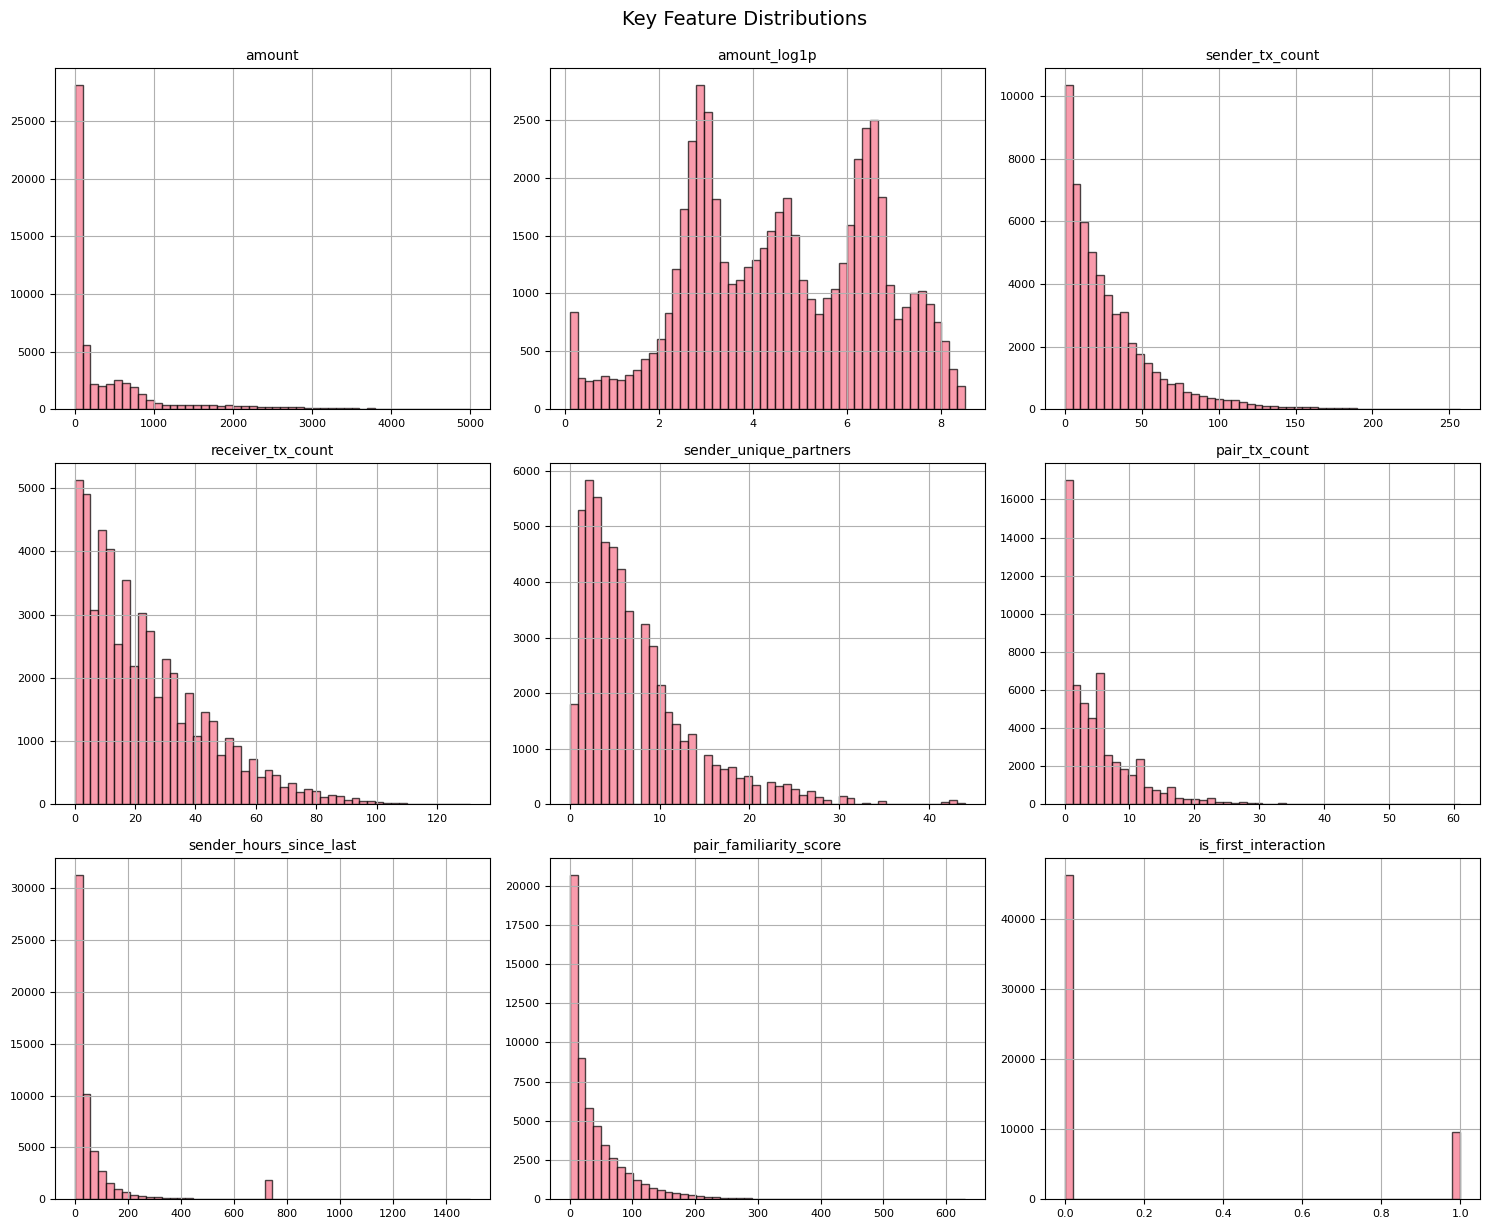


📊 Feature analysis complete!


In [9]:
# Feature distribution analysis
print("📈 Feature Distribution Analysis:\n")

# Select key features for visualization
key_features = [
    'amount', 'amount_log1p', 'sender_tx_count', 'receiver_tx_count',
    'sender_unique_partners', 'pair_tx_count', 'sender_hours_since_last',
    'pair_familiarity_score', 'is_first_interaction'
]

# Display summary statistics
summary_stats = X_train[key_features].describe()
print(summary_stats)

# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    if i < len(axes):
        # Plot distribution
        X_train[feature].hist(bins=50, alpha=0.7, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'{feature}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].tick_params(labelsize=8)

plt.tight_layout()
plt.suptitle('Key Feature Distributions', y=1.02, fontsize=14)
plt.show()

print(f"\n📊 Feature analysis complete!")

## 5. Build Baseline Fraud Detection Model

In [10]:
# Handle any remaining data quality issues
print("🔧 Preprocessing features for modeling...")

# Replace infinite values with large finite numbers
X_train_clean = X_train.replace([np.inf, -np.inf], [1e10, -1e10])
X_val_clean = X_val.replace([np.inf, -np.inf], [1e10, -1e10])

# Fill any remaining missing values
X_train_clean = X_train_clean.fillna(0)
X_val_clean = X_val_clean.fillna(0)

print(f"✅ Features preprocessed successfully!")
print(f"   Training shape: {X_train_clean.shape}")
print(f"   Validation shape: {X_val_clean.shape}")

# Train baseline model
print("\n🤖 Training baseline Random Forest model...")

baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

baseline_model.fit(X_train_clean, y_train)
print("✅ Baseline model trained successfully!")

🔧 Preprocessing features for modeling...
✅ Features preprocessed successfully!
   Training shape: (56000, 32)
   Validation shape: (14000, 32)

🤖 Training baseline Random Forest model...
✅ Baseline model trained successfully!


## 6. Model Evaluation and Performance Metrics

In [11]:
# Generate predictions
print("📊 Generating predictions and calculating metrics...\n")

# Get prediction probabilities
train_proba = baseline_model.predict_proba(X_train_clean)[:, 1]
val_proba = baseline_model.predict_proba(X_val_clean)[:, 1]

# Calculate PR-AUC
train_precision, train_recall, _ = precision_recall_curve(y_train, train_proba)
train_pr_auc = auc(train_recall, train_precision)

val_precision, val_recall, _ = precision_recall_curve(y_val, val_proba)
val_pr_auc = auc(val_recall, val_precision)

print(f"🎯 PR-AUC Scores:")
print(f"   Training PR-AUC: {train_pr_auc:.4f}")
print(f"   Validation PR-AUC: {val_pr_auc:.4f}")
print(f"   Baseline fraud rate: {y_val.mean():.4f}")

# Calculate Recall@0.5% FPR
def calculate_recall_at_fpr(y_true, y_proba, target_fpr=0.005):
    """Calculate recall at specific false positive rate"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    
    # Find threshold closest to target FPR
    target_idx = np.argmin(np.abs(fpr - target_fpr))
    achieved_fpr = fpr[target_idx]
    achieved_recall = tpr[target_idx]
    threshold = thresholds[target_idx]
    
    return achieved_recall, achieved_fpr, threshold

train_recall_at_fpr, train_fpr, train_thresh = calculate_recall_at_fpr(y_train, train_proba)
val_recall_at_fpr, val_fpr, val_thresh = calculate_recall_at_fpr(y_val, val_proba)

print(f"\n🎯 Recall@0.5% FPR:")
print(f"   Training: {train_recall_at_fpr:.4f} recall @ {train_fpr:.4f} FPR")
print(f"   Validation: {val_recall_at_fpr:.4f} recall @ {val_fpr:.4f} FPR")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 Top 10 Most Important Features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

# Store baseline metrics
baseline_metrics = {
    'train_pr_auc': train_pr_auc,
    'val_pr_auc': val_pr_auc,
    'train_recall_at_fpr': train_recall_at_fpr,
    'val_recall_at_fpr': val_recall_at_fpr,
    'val_threshold': val_thresh,
    'n_features': len(feature_cols)
}

print(f"\n✅ Baseline evaluation complete!")

📊 Generating predictions and calculating metrics...

🎯 PR-AUC Scores:
   Training PR-AUC: 0.5794
   Validation PR-AUC: 0.1590
   Baseline fraud rate: 0.0162

🎯 Recall@0.5% FPR:
   Training: 0.4394 recall @ 0.0050 FPR
   Validation: 0.1189 recall @ 0.0049 FPR

🔍 Top 10 Most Important Features:
   amount_vs_pair_avg            : 0.1805
   pair_total_amount             : 0.0998
   pair_familiarity_score        : 0.0926
   pair_avg_amount               : 0.0746
   is_first_interaction          : 0.0703
   pair_tx_count                 : 0.0584
   pair_hours_since_last         : 0.0409
   amount_sqrt                   : 0.0315
   amount_zscore                 : 0.0303
   receiver_unique_partners      : 0.0292

✅ Baseline evaluation complete!


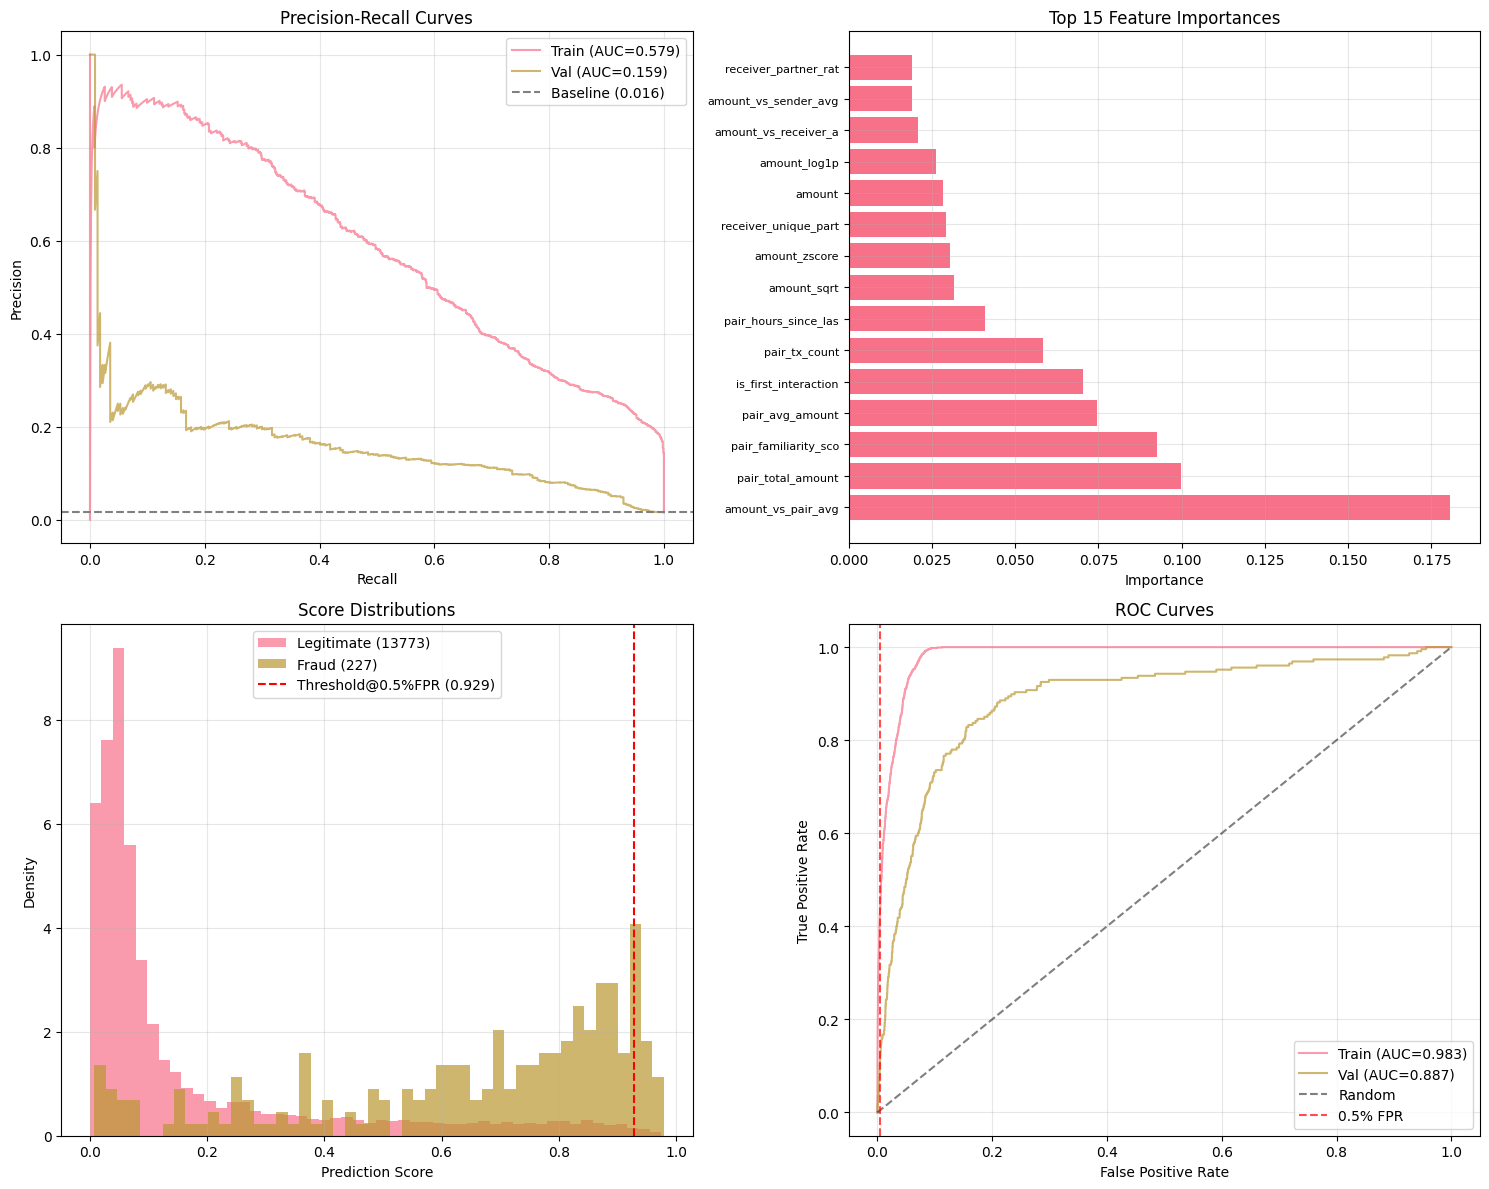

📊 Comprehensive evaluation visualizations created!


In [12]:
# Create comprehensive evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Precision-Recall Curves
axes[0, 0].plot(train_recall, train_precision, label=f'Train (AUC={train_pr_auc:.3f})', alpha=0.7)
axes[0, 0].plot(val_recall, val_precision, label=f'Val (AUC={val_pr_auc:.3f})', alpha=0.7)
axes[0, 0].axhline(y=y_val.mean(), color='gray', linestyle='--', label=f'Baseline ({y_val.mean():.3f})')
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision-Recall Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature Importance
top_features = feature_importance.head(15)
axes[0, 1].barh(range(len(top_features)), top_features['importance'])
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels([f[:20] for f in top_features['feature']], fontsize=8)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 15 Feature Importances')
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction Score Distributions
fraud_scores = val_proba[y_val == 1]
legit_scores = val_proba[y_val == 0]

axes[1, 0].hist(legit_scores, bins=50, alpha=0.7, label=f'Legitimate ({len(legit_scores)})', density=True)
axes[1, 0].hist(fraud_scores, bins=50, alpha=0.7, label=f'Fraud ({len(fraud_scores)})', density=True)
axes[1, 0].axvline(val_thresh, color='red', linestyle='--', label=f'Threshold@0.5%FPR ({val_thresh:.3f})')
axes[1, 0].set_xlabel('Prediction Score')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Score Distributions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. ROC Curve
train_fpr_roc, train_tpr_roc, _ = roc_curve(y_train, train_proba)
val_fpr_roc, val_tpr_roc, _ = roc_curve(y_val, val_proba)
train_auc_roc = auc(train_fpr_roc, train_tpr_roc)
val_auc_roc = auc(val_fpr_roc, val_tpr_roc)

axes[1, 1].plot(train_fpr_roc, train_tpr_roc, label=f'Train (AUC={train_auc_roc:.3f})', alpha=0.7)
axes[1, 1].plot(val_fpr_roc, val_tpr_roc, label=f'Val (AUC={val_auc_roc:.3f})', alpha=0.7)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[1, 1].axvline(0.005, color='red', linestyle='--', alpha=0.7, label='0.5% FPR')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Comprehensive evaluation visualizations created!")

## 7. Save Results and Prepare for Phase 2

In [13]:
# Save baseline model and features
output_path = Path('baseline_results')
output_path.mkdir(exist_ok=True)

# Save model
joblib.dump(baseline_model, output_path / 'baseline_model.pkl')
joblib.dump(feature_engineer, output_path / 'feature_engineer.pkl')

# Save feature matrices
train_baseline_features.to_csv(output_path / 'train_baseline_features.csv', index=False)
val_baseline_features.to_csv(output_path / 'val_baseline_features.csv', index=False)

# Save feature importance
feature_importance.to_csv(output_path / 'feature_importance.csv', index=False)

# Save metrics
import json
with open(output_path / 'baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

# Save predictions for later analysis
predictions_df = pd.DataFrame({
    'p2p_id': val_baseline_features['p2p_id'],
    'true_label': y_val,
    'prediction_score': val_proba,
    'prediction_binary': (val_proba >= val_thresh).astype(int)
})
predictions_df.to_csv(output_path / 'baseline_predictions.csv', index=False)

print(f"💾 Results saved to: {output_path}")
print(f"📁 Files created:")
for file in output_path.glob('*'):
    print(f"   - {file.name}")

print(f"\n🎉 Phase 1 completed successfully!")
print(f"📊 Baseline Performance Summary:")
print(f"   ✅ Validation PR-AUC: {val_pr_auc:.4f}")
print(f"   ✅ Recall@0.5% FPR: {val_recall_at_fpr:.4f}")
print(f"   ✅ Features generated: {len(feature_cols)}")
print(f"   ✅ No temporal leakage detected")

print(f"\n🚀 Ready for Phase 2: Graph Embeddings!")
print(f"   Target: Beat PR-AUC {val_pr_auc:.4f} with graph features")
print(f"   Target: Beat Recall@0.5%FPR {val_recall_at_fpr:.4f} with network analysis")

💾 Results saved to: baseline_results
📁 Files created:
   - train_baseline_features.csv
   - feature_engineer.pkl
   - baseline_model.pkl
   - baseline_metrics.json
   - feature_importance.csv
   - val_baseline_features.csv
   - baseline_predictions.csv

🎉 Phase 1 completed successfully!
📊 Baseline Performance Summary:
   ✅ Validation PR-AUC: 0.1590
   ✅ Recall@0.5% FPR: 0.1189
   ✅ Features generated: 32
   ✅ No temporal leakage detected

🚀 Ready for Phase 2: Graph Embeddings!
   Target: Beat PR-AUC 0.1590 with graph features
   Target: Beat Recall@0.5%FPR 0.1189 with network analysis
